In [930]:
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from IPython.core.display import clear_output
from IPython.display import Image  
from math import sqrt
from matplotlib.pylab import rcParams
from pandas import DataFrame
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
from pprint import pprint
from pylab import rcParams
from scipy import stats
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals.six import StringIO  
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statistics import mean
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from subprocess import call
from termcolor import colored
from time import sleep
from tqdm import tqdm, tqdm_notebook
from tqdm.notebook import trange, tqdm, tnrange
from xgboost import plot_importance, plot_tree, XGBClassifier
from xgboost.sklearn import XGBClassifier
import datetime as dt
import getpass
import graphviz
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pmdarima as pm
import pycountry
import pycountry_convert as pc
import pydotplus
import pyodbc 
import seaborn as sns
import sklearn.linear_model as lm
import statsmodels.api as sm
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

## Data load

In [931]:
url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
df = pd.read_csv(url,index_col=0)
df.head(5)

,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
Date,,,,,,,
2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


In [932]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 17920 entries, 2020-01-22 to 2020-03-31
Data columns (total 7 columns):
Country/Region    17920 non-null object
Province/State    5530 non-null object
Lat               17920 non-null float64
Long              17920 non-null float64
Confirmed         17850 non-null float64
Recovered         16940 non-null float64
Deaths            17850 non-null float64
dtypes: float64(5), object(2)
memory usage: 1.1+ MB


In [933]:
df = df.rename(columns={'Province/State': 'Province', 'Country/Region': 'Country'})
df.shape

(17920, 7)

In [934]:
df['Province_and_country'] = df['Country'].map(str) + "_" + df['Province'].map(str)
df['Province_and_country'] = df['Province_and_country'].str.replace('_nan', '').map(str)

In [935]:
df['Days_since_outbreak_global'] = df.groupby(['Province_and_country','Lat','Long']).cumcount()+1

In [936]:
df.head()

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global
Date,,,,,,,,,
2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,1
2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,2
2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,3
2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,4
2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0,Afghanistan,5


In [937]:
df.to_csv('df_m.CSV',sep=',')

## Analysis - Amount of cases

In [938]:
len(df['Province_and_country'].unique())

256

In [939]:
len(df['Country'].unique())

180

In [940]:
len(df['Province'].unique())

80

In [941]:
df.describe()

,Lat,Long,Confirmed,Recovered,Deaths,Days_since_outbreak_global
count,17920.000000,17920.000000,17850.000000,16940.000000,17850.000000,17920.000000
mean,22.043202,22.743415,594.082633,182.274321,24.313557,35.500000
std,24.492118,71.427897,5416.797842,2393.502664,311.842784,20.205761
min,-41.454500,-135.000000,0.000000,0.000000,0.000000,1.000000
25%,8.332041,-20.026050,0.000000,0.000000,0.000000,18.000000
50%,23.764900,20.921188,0.000000,0.000000,0.000000,35.500000
75%,41.316075,84.497525,34.000000,1.000000,0.000000,53.000000
max,71.706900,178.065000,188172.000000,63153.000000,12428.000000,70.000000


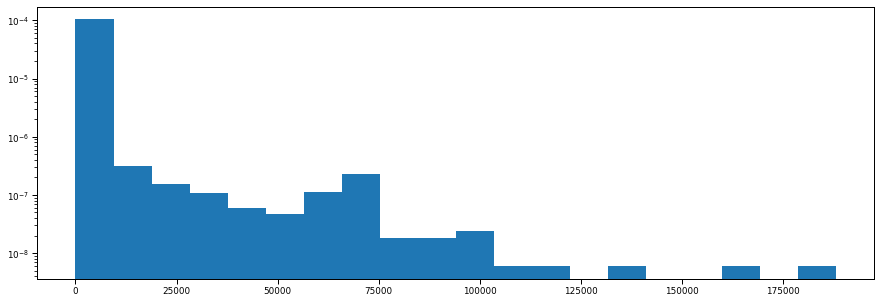

In [942]:
plt.hist(df['Confirmed'], density=True, bins=20) 
plt.yscale('log')

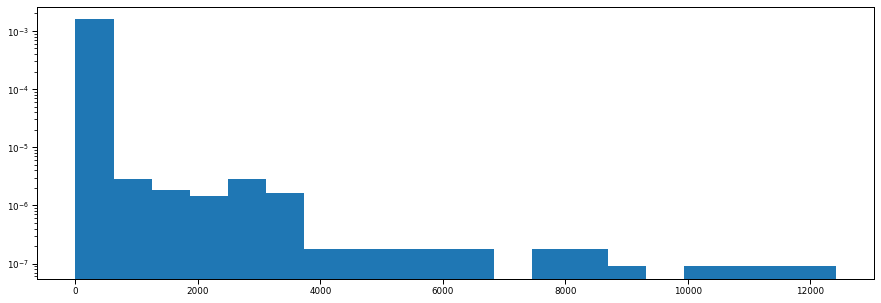

In [943]:
plt.hist(df['Deaths'], density=True, bins=20) 
plt.yscale('log')

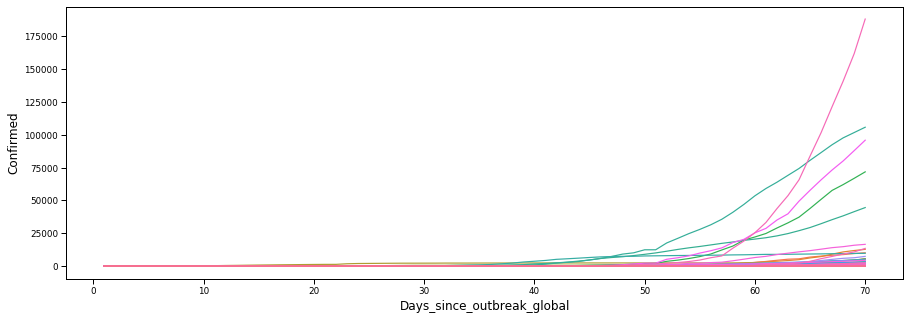

In [944]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Confirmed", ci=None)
ax.legend_.remove()

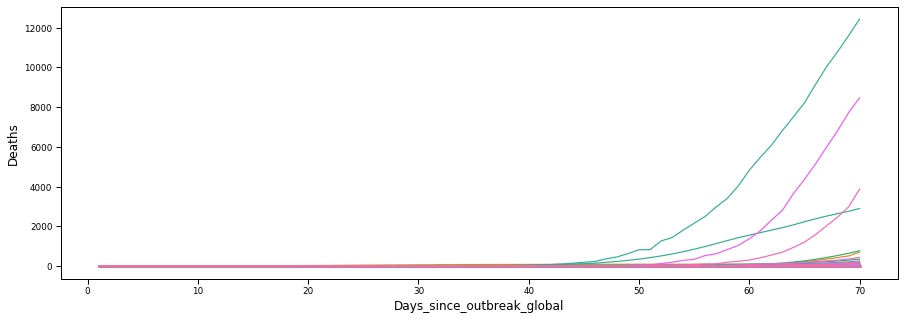

In [946]:
ax=sns.lineplot(data=df, hue="Country", x="Days_since_outbreak_global", y="Deaths", ci=None)
ax.legend_.remove()

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...     61     62     63     64     65     66  \
Country                     ...                                             
Afghanistan                 ...   40.0   40.0   74.0   84.0   94.0  110.0   
Albania                     ...   89.0  104.0  123.0  146.0  174.0  186.0   
Algeria                     ...  201.0  230.0  264.0  302.0  367.0  409.0   
Andorra                     ...  113.0  133.0  164.0  

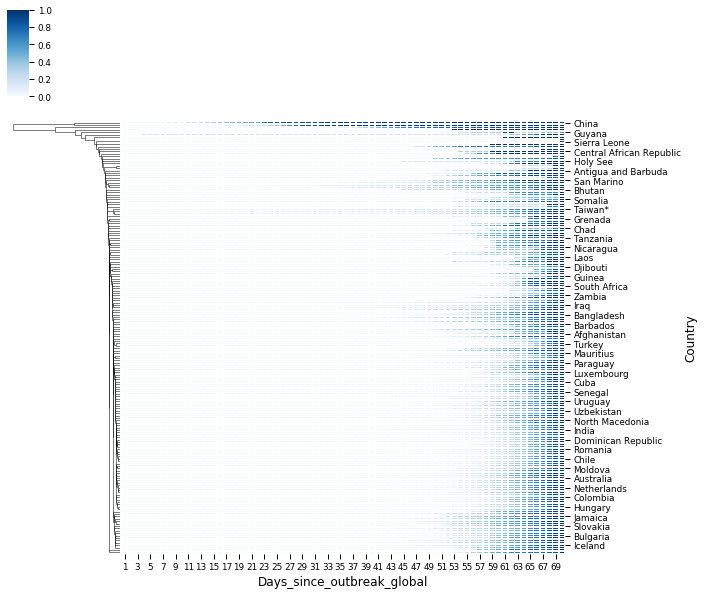

<Figure size 1800x576 with 0 Axes>

In [947]:
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":12,"axes.labelsize":12})   
def group_and_chart(Geography, Figure, Data):
    grouped = Data.groupby(['Days_since_outbreak_global',Geography])[Figure].sum()
    grouped= pd.DataFrame(grouped) 
    grouped.reset_index(inplace=True)
    grouped=grouped.pivot(index='Days_since_outbreak_global', columns=Geography, values=Figure)
    grouped = grouped.T[(grouped != 0).any()].T
    grouped = grouped.transpose()
    grouped.fillna(0, inplace=True)
    print(grouped.head())
    sns.clustermap(grouped, cmap="Blues", linewidth=.5, standard_scale=0,  col_cluster=False, method='single')
    plt.figure(figsize=(25,8))
    
group_and_chart(Geography='Country', Figure='Confirmed', Data=df)

In [948]:
# function for getting the iso code through fuzzy search
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_2

# manually change name of some countries
df.loc[df['Country'] == 'Korea, South', 'Country'] = 'Korea, Republic of'
df.loc[df['Country'] == 'Taiwan*', 'Country'] = 'Taiwan'
df.loc[df['Country'] == 'Burma', 'Country'] = 'Myanmar'
df.loc[df['Country'] == 'Holy See', 'Country'] = 'Italy'
df.loc[df['Country'] == 'Laos', 'Country'] = "Lao"
df.loc[df['Country'] == "Congo (Kinshasa)", 'Country'] = "Congo"
df.loc[df['Country'] == "Congo (Brazzaville)", 'Country'] = "Congo"
df.loc[df['Country'] == "West Bank and Gaza", 'Country'] = "Palestine"

# create iso mapping for countries in df
iso_map = {country: do_fuzzy_search(country) for country in df['Country'].unique()}
# apply the mapping to df
df['iso'] = df['Country'].map(iso_map)

In [949]:
def alpha2_to_continent(iso):
    try: cont = pc.country_alpha2_to_continent_code(iso)
    except: cont = float('NaN')
    return cont

df['Continent'] = df['iso'].apply(alpha2_to_continent) # get continent code

df.loc[df['Country'] == "Congo", 'Continent'] = "AF"
df.loc[df['Country'] == 'Timor-Leste', 'Continent'] = 'AS'
df.loc[df['Country'] == 'Diamond Princess', 'Continent'] = 'Diamond Princess'

df['Continent'] = df['Continent'].map({'Diamond Princess':'Diamond Princess','AF':'Africa','AS':'Asia','EU':'Europe','NA':'North America','OC':'Oceania','SA':'South America'})

Days_since_outbreak_global     1      2      3       4       5       6   \
Continent                                                                 
Africa                        0.0    0.0    0.0     0.0     0.0     0.0   
Asia                        554.0  653.0  937.0  1429.0  2105.0  2912.0   
Diamond Princess              0.0    0.0    0.0     0.0     0.0     0.0   
Europe                        0.0    0.0    2.0     3.0     3.0     4.0   
North America                 1.0    1.0    2.0     2.0     6.0     6.0   

Days_since_outbreak_global      7       8       9       10  ...        61  \
Continent                                                   ...             
Africa                         0.0     0.0     0.0     0.0  ...    1437.0   
Asia                        5558.0  6143.0  8208.0  9889.0  ...  123216.0   
Diamond Princess               0.0     0.0     0.0     0.0  ...     712.0   
Europe                         8.0    10.0    10.0    18.0  ...  169984.0   
North Americ

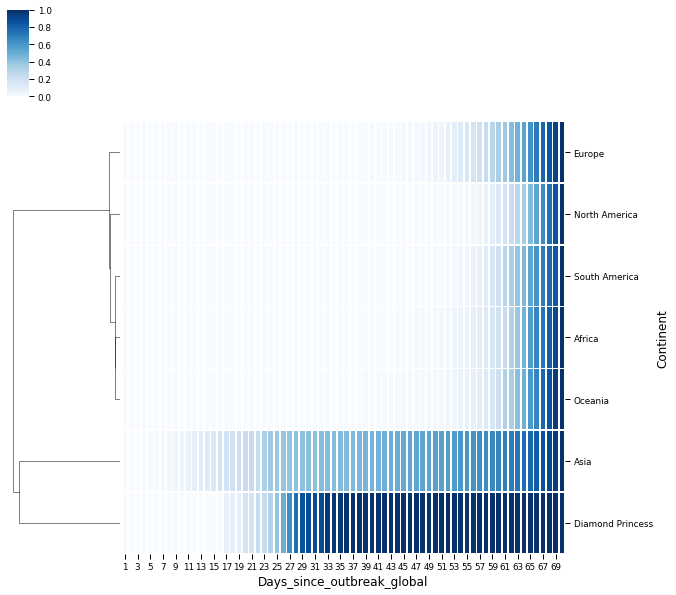

<Figure size 1800x576 with 0 Axes>

In [950]:
group_and_chart(Geography='Continent', Figure='Confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Armenia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Azerbaijan                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahrain                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bangladesh                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...     61     62     63     64     65     66  \
Country                     ...                                             
Afghanistan                 ...   40.0   40.0   74.0   84.0   94.0  110.0   
Armenia                     ...  194.0  235.0  249.0  265.0  290.0  329.0   
Azerbaijan                  ...   65.0   72.0   87.0   93.0  122.0  165.0   
Bahrain                     ...  334.0  377.0  392.0  

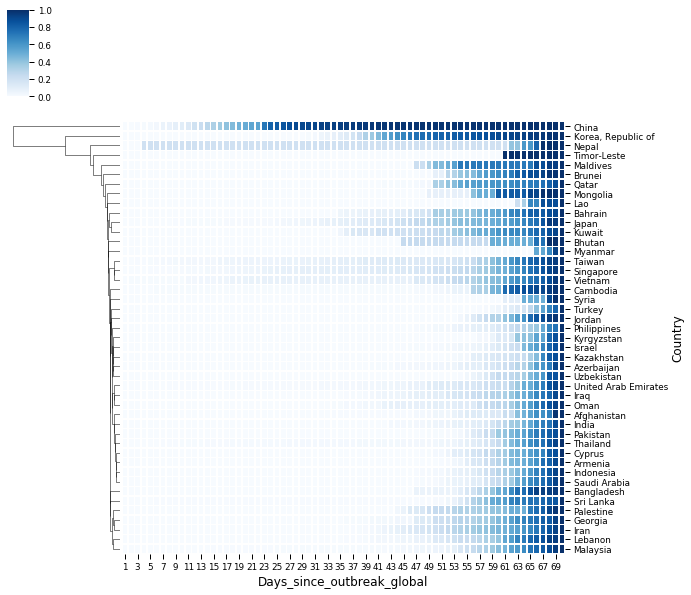

<Figure size 1800x576 with 0 Axes>

In [951]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Austria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belarus                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belgium                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...      61      62      63      64      65  \
Country                     ...                                           
Albania                     ...    89.0   104.0   123.0   146.0   174.0   
Andorra                     ...   113.0   133.0   164.0   188.0   224.0   
Austria                     ...  3582.0  4474.0  5283.0  5588.0  6909.0   
Belarus                     ...    76.0    81.0    81.0    86.0 

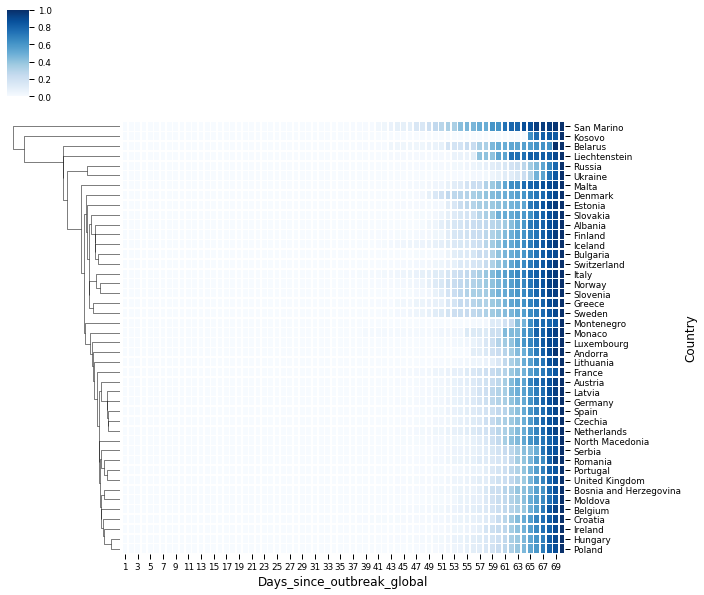

<Figure size 1800x576 with 0 Axes>

In [952]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Benin                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Botswana                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Burkina Faso                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...     61     62     63     64     65     66  \
Country                     ...                                             
Algeria                     ...  201.0  230.0  264.0  302.0  367.0  409.0   
Angola                      ...    2.0    3.0    3.0    3.0    4.0    4.0   
Benin                       ...    2.0    5.0    6.0    6.0    6.0    6.0   
Botswana                    ...    0.0    0.0    0.0  

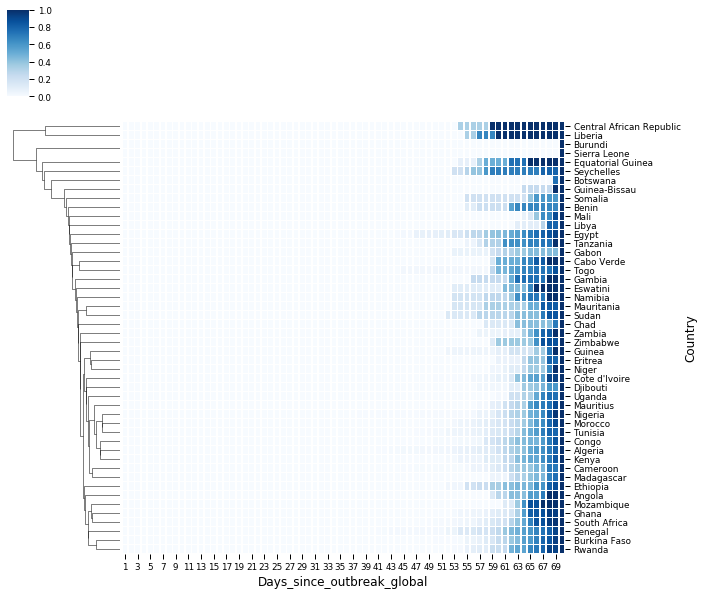

<Figure size 1800x576 with 0 Axes>

In [953]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahamas                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Barbados                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belize                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Canada                      0.0  0.0  0.0  0.0  1.0  1.0  2.0  2.0  2.0  4.0   

Days_since_outbreak_global  ...      61      62      63      64      65  \
Country                     ...                                           
Antigua and Barbuda         ...     1.0     3.0     3.0     3.0     7.0   
Bahamas                     ...     4.0     4.0     5.0     5.0     9.0   
Barbados                    ...    14.0    17.0    18.0    18.0    18.0   
Belize                      ...     0.0     1.0     1.0     2.0 

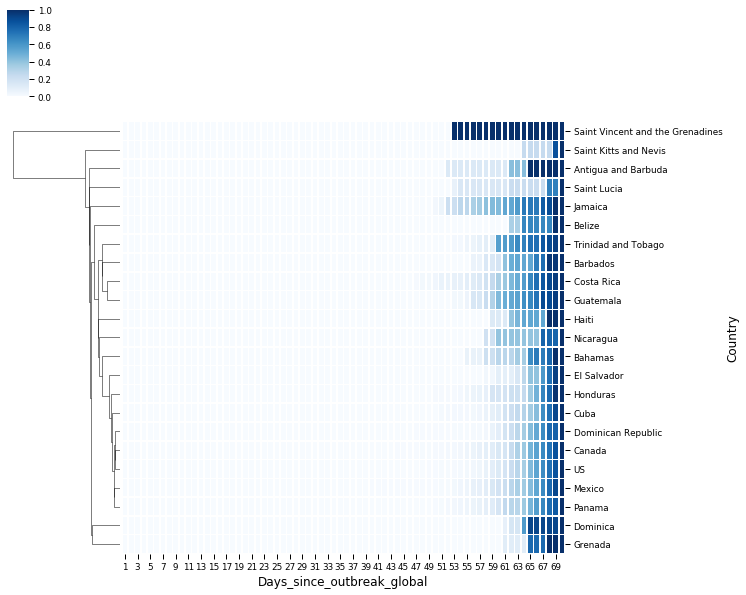

<Figure size 1800x576 with 0 Axes>

In [954]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Australia                   0.0  0.0  0.0  0.0  4.0  5.0  5.0  6.0  9.0  9.0   
Fiji                        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
New Zealand                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Papua New Guinea            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...      61      62      63      64      65  \
Country                     ...                                           
Australia                   ...  1549.0  1682.0  2044.0  2364.0  2810.0   
Fiji                        ...     2.0     3.0     4.0     5.0     5.0   
New Zealand                 ...   102.0   102.0   155.0   205.0   283.0   
Papua New Guinea            ...     1.0     1.0     1.0     1.0     1.0   

Days_since_outbreak_global      66      67      68      69      70  

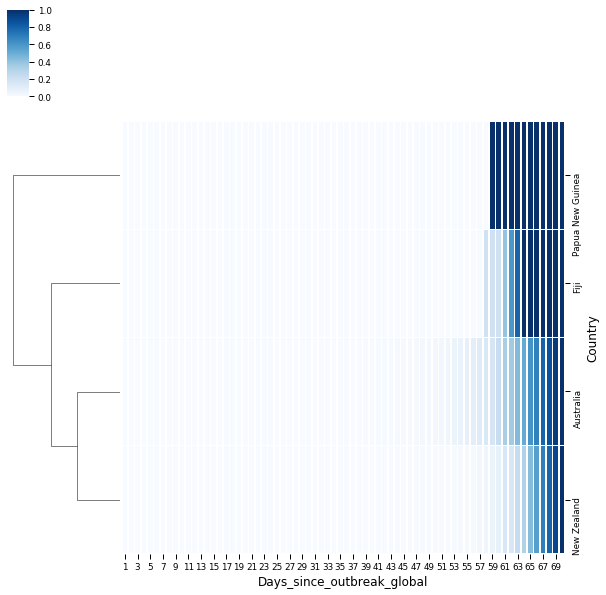

<Figure size 1800x576 with 0 Axes>

In [955]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bolivia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Brazil                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Chile                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Colombia                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...      61      62      63      64      65  \
Country                     ...                                           
Argentina                   ...   266.0   301.0   387.0   387.0   502.0   
Bolivia                     ...    24.0    27.0    29.0    32.0    43.0   
Brazil                      ...  1546.0  1924.0  2247.0  2554.0  2985.0   
Chile                       ...   632.0   746.0   922.0  1142.0 

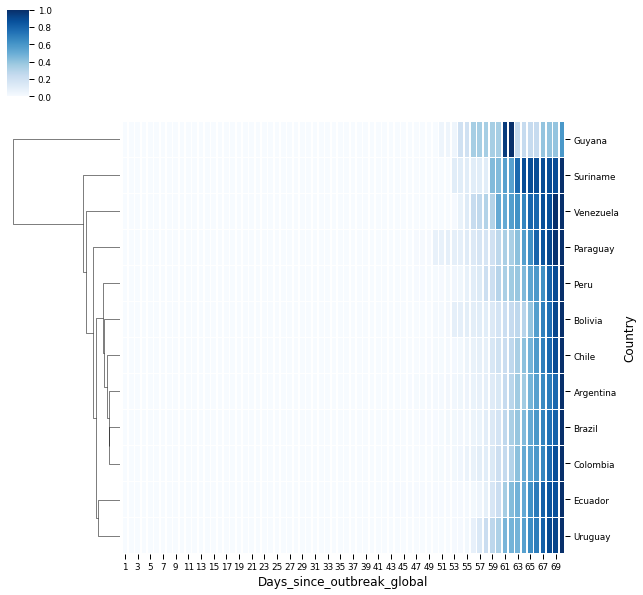

<Figure size 1800x576 with 0 Axes>

In [956]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Confirmed', Data=df_)

## Analysis - daily increase

In [957]:
df['Date'] = df.index
df = df.reset_index(drop = True)
df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Week_number'] = df['Date'].dt.week
df['Quarter'] = df['Date'].dt.quarter
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Confirmed_lag_1'] = df.groupby('Province_and_country')['Confirmed'].shift(1)
df['Daily_increase_confirmed'] = (df['Confirmed']/df['Confirmed_lag_1'])-1
df['Deaths_lag_1'] = df.groupby('Province_and_country')['Deaths'].shift(1)
df['Daily_increase_death'] = (df['Deaths']/df['Deaths_lag_1'])-1
df = df.replace([np.inf, -np.inf], np.nan)
#df.loc[df['Daily_increase_confirmed'] == np.inf, 'Daily_increase_confirmed'] = df['Confirmed']
#df.loc[df['Daily_increase_death'] == np.inf, 'Daily_increase_death'] = df['Deaths']
df = df.replace(np.nan, 0)
df

,Country,Province,Lat,Long,Confirmed,Recovered,Deaths,Province_and_country,Days_since_outbreak_global,iso,...,Day,Weekday,Week_number,Quarter,Month,Year,Confirmed_lag_1,Daily_increase_confirmed,Deaths_lag_1,Daily_increase_death
0,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,1,AF,...,22,2,4,1,1,2020,0.0,0.000000,0.0,0.0
1,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,2,AF,...,23,3,4,1,1,2020,0.0,0.000000,0.0,0.0
2,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,3,AF,...,24,4,4,1,1,2020,0.0,0.000000,0.0,0.0
3,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,4,AF,...,25,5,4,1,1,2020,0.0,0.000000,0.0,0.0
4,Afghanistan,0,33.0,65.0,0.0,0.0,0.0,Afghanistan,5,AF,...,26,6,4,1,1,2020,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17915,Zimbabwe,0,-20.0,30.0,5.0,0.0,1.0,Zimbabwe,66,ZW,...,27,4,13,1,3,2020,3.0,0.666667,1.0,0.0
17916,Zimbabwe,0,-20.0,30.0,7.0,0.0,1.0,Zimbabwe,67,ZW,...,28,5,13,1,3,2020,5.0,0.400000,1.0,0.0
17917,Zimbabwe,0,-20.0,30.0,7.0,0.0,1.0,Zimbabwe,68,ZW,...,29,6,13,1,3,2020,7.0,0.000000,1.0,0.0
17918,Zimbabwe,0,-20.0,30.0,7.0,0.0,1.0,Zimbabwe,69,ZW,...,30,0,14,1,3,2020,7.0,0.000000,1.0,0.0


In [958]:
df.to_csv('df_m.CSV',sep=',')

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        61        62        63        64  \
Country                     ...                                           
Afghanistan                 ...  0.666667  0.000000  0.850000  0.135135   
Albania                     ...  0.171053  0.168539  0.182692  0.186992   
Algeria                     ...  0.446043  0.144279  0.147826  0.143939   
Andorra                     ...  0.284091  0.176991  0.233083  0

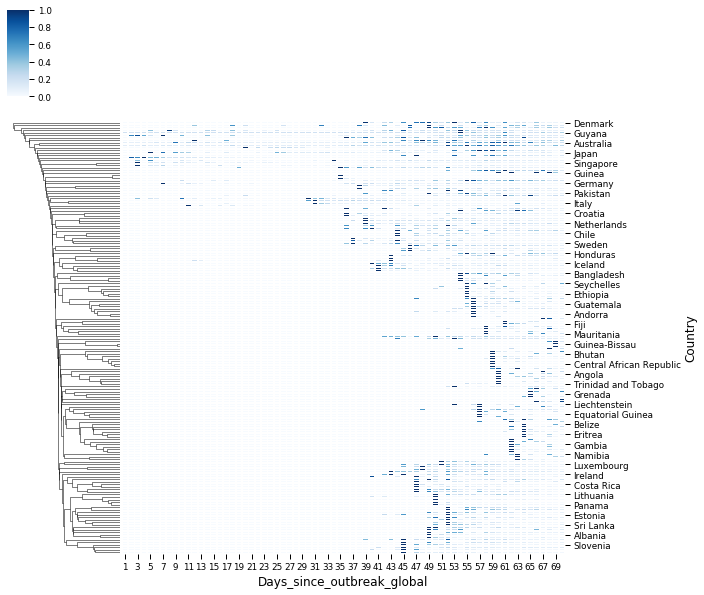

<Figure size 1800x576 with 0 Axes>

In [959]:
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1          2          3          4          5   \
Continent                                                                     
Africa                      0.0   0.000000   0.000000   0.000000   0.000000   
Asia                        0.0  32.879976  31.618121  39.505271  19.947801   
Diamond Princess            0.0   0.000000   0.000000   0.000000   0.000000   
Europe                      0.0   0.000000   0.000000   0.500000   0.000000   
North America               0.0   0.000000   1.000000   0.000000   1.500000   

Days_since_outbreak_global         6          7         8         9   \
Continent                                                              
Africa                       0.000000   0.000000  0.000000  0.000000   
Asia                        20.027021  15.679485  7.478922  9.050445   
Diamond Princess             0.000000   0.000000  0.000000  0.000000   
Europe                       0.000000   3.333333  0.250000  0.000000   
North America 

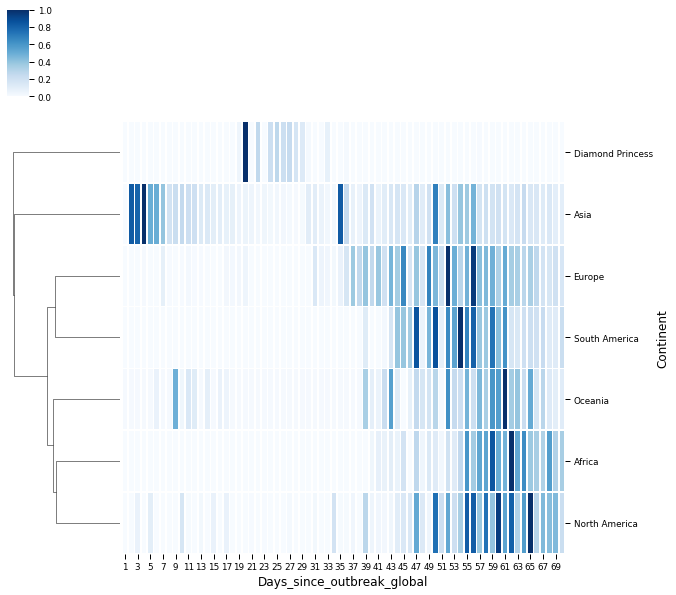

<Figure size 1800x576 with 0 Axes>

In [960]:
group_and_chart(Geography='Continent', Figure='Daily_increase_confirmed', Data=df)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Afghanistan                 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Armenia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Azerbaijan                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahrain                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bangladesh                  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        61        62        63        64  \
Country                     ...                                           
Afghanistan                 ...  0.666667  0.000000  0.850000  0.135135   
Armenia                     ...  0.212500  0.211340  0.059574  0.064257   
Azerbaijan                  ...  0.226415  0.107692  0.208333  0.068966   
Bahrain                     ...  0.095082  0.128743  0.039788  0

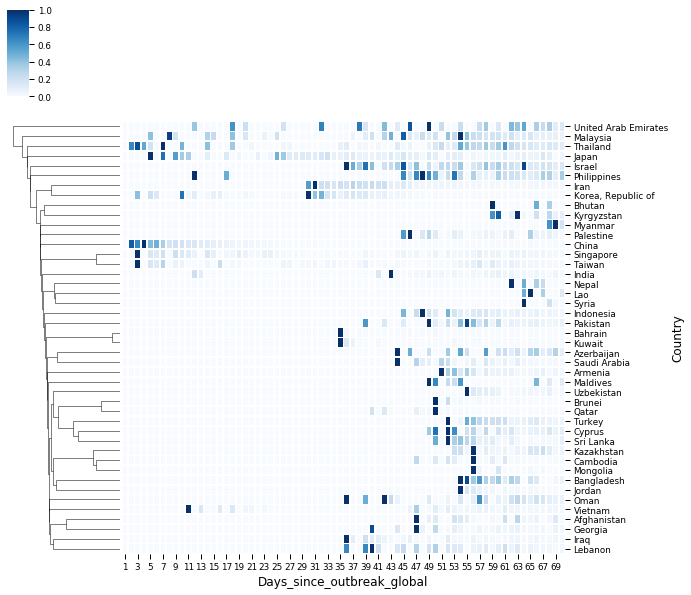

<Figure size 1800x576 with 0 Axes>

In [961]:
df_ = df.loc[(df.Continent == 'Asia')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Albania                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Andorra                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Austria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belarus                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belgium                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        61        62        63        64  \
Country                     ...                                           
Albania                     ...  0.171053  0.168539  0.182692  0.186992   
Andorra                     ...  0.284091  0.176991  0.233083  0.146341   
Austria                     ...  0.272921  0.249023  0.180823  0.057732   
Belarus                     ...  0.000000  0.065789  0.000000  0

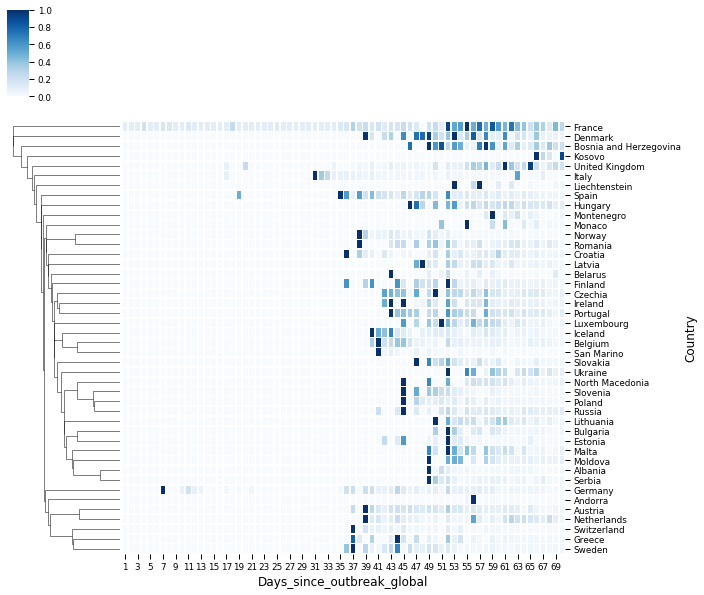

<Figure size 1800x576 with 0 Axes>

In [962]:
df_ = df.loc[(df.Continent == 'Europe')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Algeria                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Angola                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Benin                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Botswana                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Burkina Faso                0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        61        62        63        64  \
Country                     ...                                           
Algeria                     ...  0.446043  0.144279  0.147826  0.143939   
Angola                      ...  0.000000  0.500000  0.000000  0.000000   
Benin                       ...  0.000000  1.500000  0.200000  0.000000   
Botswana                    ...  0.000000  0.000000  0.000000  0

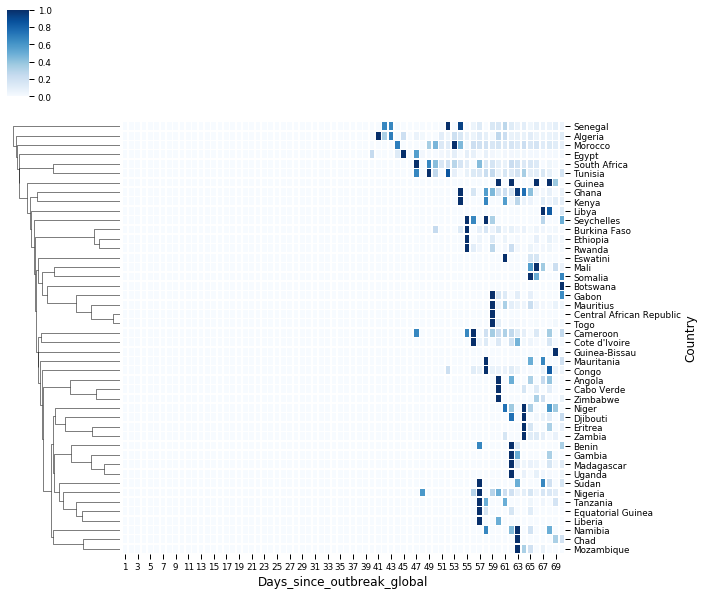

<Figure size 1800x576 with 0 Axes>

In [963]:
df_ = df.loc[(df.Continent == 'Africa')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Antigua and Barbuda         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bahamas                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Barbados                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Belize                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Canada                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0   

Days_since_outbreak_global  ...        61        62        63        64  \
Country                     ...                                           
Antigua and Barbuda         ...  0.000000  2.000000  0.000000  0.000000   
Bahamas                     ...  0.000000  0.000000  0.250000  0.000000   
Barbados                    ...  1.333333  0.214286  0.058824  0.000000   
Belize                      ...  0.000000  0.000000  0.000000  1

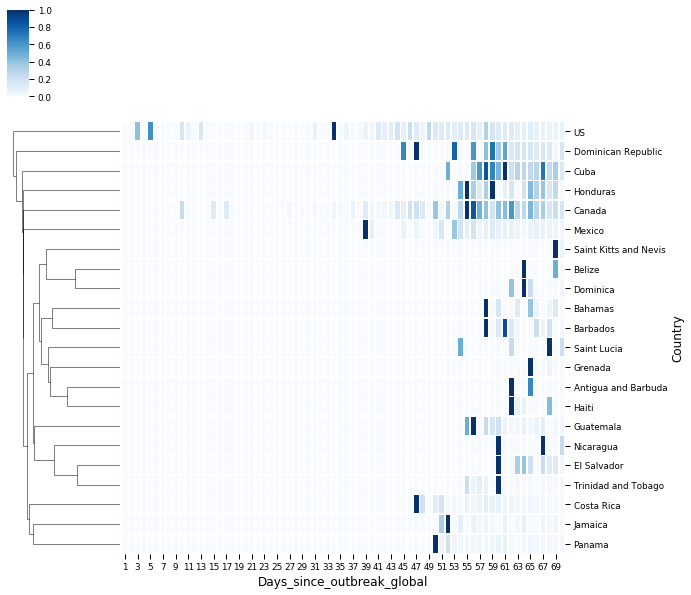

<Figure size 1800x576 with 0 Axes>

In [964]:
df_ = df.loc[(df.Continent == 'North America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5         6    7    8    9   \
Country                                                                        
Australia                   0.0  0.0  0.0  0.0  0.0  0.333333  0.0  0.0  3.0   
Fiji                        0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   
New Zealand                 0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0   

Days_since_outbreak_global        10  ...        61        62        63  \
Country                               ...                                 
Australia                   0.166667  ...  4.235216  1.695265  1.562388   
Fiji                        0.000000  ...  1.000000  0.500000  0.333333   
New Zealand                 0.000000  ...  0.961538  0.000000  0.519608   

Days_since_outbreak_global        64        65        66        67        68  \
Country                                                                        
Australia                   0.793349  2.780275  0.645619  1.504

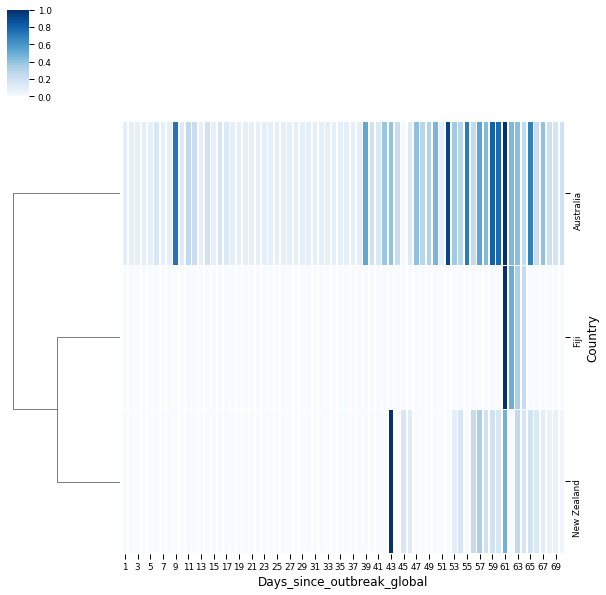

<Figure size 1800x576 with 0 Axes>

In [965]:
df_ = df.loc[(df.Continent == 'Oceania')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

Days_since_outbreak_global   1    2    3    4    5    6    7    8    9    10  \
Country                                                                        
Argentina                   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Bolivia                     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Brazil                      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Chile                       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
Colombia                    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Days_since_outbreak_global  ...        61        62        63        64  \
Country                     ...                                           
Argentina                   ...  0.683544  0.131579  0.285714  0.000000   
Bolivia                     ...  0.263158  0.125000  0.074074  0.103448   
Brazil                      ...  0.514202  0.244502  0.167879  0.136627   
Chile                       ...  0.176909  0.180380  0.235925  0

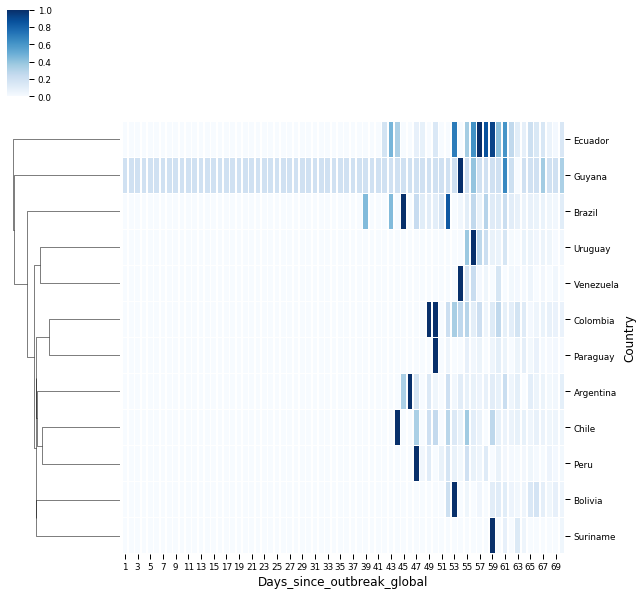

<Figure size 1800x576 with 0 Axes>

In [966]:
df_ = df.loc[(df.Continent == 'South America')]
group_and_chart(Geography='Country', Figure='Daily_increase_confirmed', Data=df_)

## Prediction - preperation

In [967]:
#Confirmed
df_ml_confirmed = df
df_ml_confirmed['Confirmed_lag_7'] = df_ml_confirmed.groupby('Province_and_country')['Confirmed'].shift(7)
df_ml_confirmed['Days_since_outbreak_country'] = df_ml_confirmed.loc[(df_ml_confirmed.Confirmed.notnull())].groupby(['Province_and_country','Lat','Long']).cumcount()+1
df_ml_confirmed = df_ml_confirmed.replace(np.nan, 0)
df_ml_confirmed = df_ml_confirmed[['Confirmed', 'Province_and_country', 'Days_since_outbreak_global', 'Date','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]

In [968]:
df_ml.to_csv('df_ml.CSV',sep=',')

### One Country Test

In [969]:
split_date = datetime.today() - timedelta(days=8)
split_date

datetime.datetime(2020, 3, 24, 20, 4, 42, 103189)

In [970]:
def create_x_y(df, label=None):
    df.index = df['Date']
    X = df[['Days_since_outbreak_global','Day','Weekday','Week_number','Quarter','Month','Year', 'Confirmed_lag_7','Days_since_outbreak_country']]
    if label:
        y = df[label]
        return X, y
    return X

31681.80118483256
177.99382344573803
2.750481878736401
-0.5380166833691322


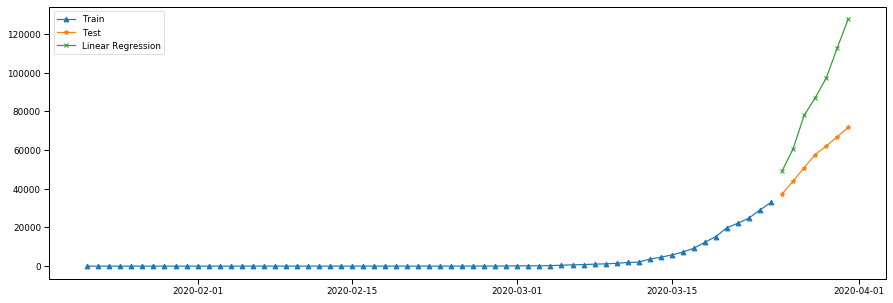

In [971]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]
 
Confirmed_train = List.loc[List.Date <= split_date].copy()
Confirmed_test = List.loc[List.Date > split_date].copy()

X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

linear_regressor.fit(X_train, y_train)

Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)

plt.plot(Confirmed_train.index, Confirmed_train['Confirmed'], label='Train',marker ='^')
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed'], label='Test', marker = "*")
plt.plot(Confirmed_test.index, Confirmed_test['Confirmed_Prediction'], label='Linear Regression', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])))
print(SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
print(mean((Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']))

6681.236106007255
81.73882863124021
0.5800370607063209
0.10991179107319976


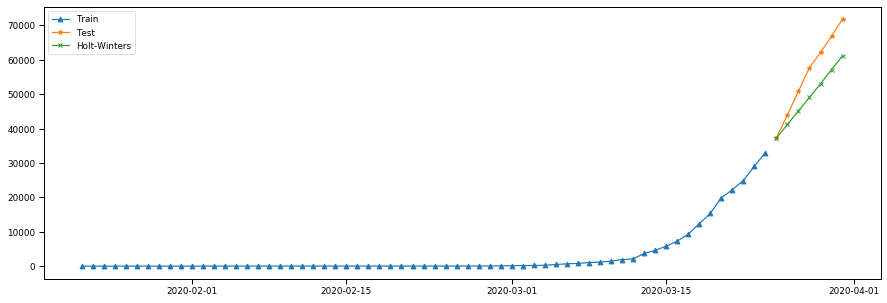

In [972]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))
print(mean((test.Confirmed - pred.Confirmed) / test.Confirmed))

In [973]:
def exp_smoothing_configs(seasonal=[None]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

cfg_list = exp_smoothing_configs(seasonal=[6]) #[0,6,12]

In [974]:
edf = List['Confirmed']
ts = edf[:split_date].copy()
ts_v = edf[split_date:].copy()
ind = edf.index[-7:]  

print("Holt's Winter Model")
best_RMSE = np.inf
best_config = []
t1 = d1 = s1 = p1 = b1 = r1 = ''
for j in range(len(cfg_list)):
    print(j)
    try:
        cg = cfg_list[j]
        print(cg)
        t,d,s,p,b,r = cg
        train = edf[:split_date].copy()
        test = edf[split_date:split_date+timedelta(days=7)].copy()
        # define model
        if (t == None):
            model = ExponentialSmoothing(ts, trend=t, seasonal=s, seasonal_periods=p)
        else:
            model = ExponentialSmoothing(ts, trend=t, damped=d, seasonal=s, seasonal_periods=p)
        # fit model
        model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
        # make one step forecast
        y_forecast = model_fit.forecast(7)
        rmse = np.sqrt(mean_squared_error(ts_v,y_forecast))
        print(rmse)
        if rmse < best_RMSE:
            best_RMSE = rmse
            best_config = cfg_list[j]
    except:
        continue

Holt's Winter Model
0
['add', True, 'add', 6, True, True]
1
['add', True, 'add', 6, True, False]
2
['add', True, 'add', 6, False, True]
7803.011557192588
3
['add', True, 'add', 6, False, False]
7882.752041046593
4
['add', True, 'mul', 6, True, True]
5
['add', True, 'mul', 6, True, False]
6
['add', True, 'mul', 6, False, True]
7
['add', True, 'mul', 6, False, False]
8
['add', True, None, 6, True, True]
9
['add', True, None, 6, True, False]
10
['add', True, None, 6, False, True]
7978.931143463041
11
['add', True, None, 6, False, False]
8061.646782332992
12
['add', False, 'add', 6, True, True]
13
['add', False, 'add', 6, True, False]
14
['add', False, 'add', 6, False, True]
7774.995728271595
15
['add', False, 'add', 6, False, False]
7854.455714319434
16
['add', False, 'mul', 6, True, True]
17
['add', False, 'mul', 6, True, False]
18
['add', False, 'mul', 6, False, True]
19
['add', False, 'mul', 6, False, False]
20
['add', False, None, 6, True, True]
21
['add', False, None, 6, True, False]

In [975]:
def model_eval(y, predictions):

    # Import library for metrics
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

    # Mean absolute error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Mean squared error (MSE)
    mse = mean_squared_error(y, predictions)


    # SMAPE is an alternative for MAPE when there are zeros in the testing data. It
    # scales the absolute percentage by the sum of forecast and observed values
    SMAPE = np.mean(np.abs((y - predictions) / ((y + predictions)/2))) * 100


    # Calculate the Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y, predictions))

    # Calculate the Mean Absolute Percentage Error
    # y, predictions = check_array(y, predictions)
    MAPE = np.mean(np.abs((y - predictions) / y)) * 100

    # mean_forecast_error
    mfe = np.mean(y - predictions)

    # NMSE normalizes the obtained MSE after dividing it by the test variance. It
    # is a balanced error measure and is very effective in judging forecast
    # accuracy of a model.

    # normalised_mean_squared_error
    NMSE = mse / (np.sum((y - np.mean(y)) ** 2)/(len(y)-1))


    # theil_u_statistic
    # It is a normalized measure of total forecast error.
    error = y - predictions
    mfe = np.sqrt(np.mean(predictions**2))
    mse = np.sqrt(np.mean(y**2))
    rmse = np.sqrt(np.mean(error**2))
    theil_u_statistic =  rmse / (mfe*mse)


    # mean_absolute_scaled_error
    # This evaluation metric is used to over come some of the problems of MAPE and
    # is used to measure if the forecasting model is better than the naive model or
    # not.


    # Print metrics
    print('Mean Absolute Error:', round(mae, 3))
    print('Mean Squared Error:', round(mse, 3))
    print('Root Mean Squared Error:', round(rmse, 3))
    print('Mean absolute percentage error:', round(MAPE, 3))
    print('Scaled Mean absolute percentage error:', round(SMAPE, 3))
    print('Mean forecast error:', round(mfe, 3))
    print('Normalised mean squared error:', round(NMSE, 3))
    print('Theil_u_statistic:', round(theil_u_statistic, 3))

In [976]:
print(best_RMSE, best_config)

t1,d1,s1,p1,b1,r1 = best_config

if t1 == None:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1)
else:
    hw_model1 = ExponentialSmoothing(ts, trend=t1, seasonal=s1, seasonal_periods=p1, damped=d1)

fit2 = hw_model1.fit(optimized=True, use_boxcox=b1, remove_bias=r1)

#pred_HW = fit2.predict(start=pd.to_datetime('01-Apr-2019'), end = pd.to_datetime('29-Feb-2020'))
pred_HW = fit2.forecast(7)

pred_HW = pd.Series(data=pred_HW, index=ind)
df_pass_pred = pd.concat([List, pred_HW.rename('pred_HW')], axis=1)

print(model_eval(ts_v, pred_HW))
print('-*-'*20)

# 15.570830579664698 ['add', True, 'add', 12, False, False]
# Mean Absolute Error: 10.456
# Mean Squared Error: 481.948
# Root Mean Squared Error: 15.571
# Mean absolute percentage error: 2.317
# Scaled Mean absolute percentage error: 2.273
# Mean forecast error: 483.689
# Normalised mean squared error: 0.04
# Theil_u_statistic: 0.0
# None
# -*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-

7774.995728271595 ['add', False, 'add', 6, False, True]
Mean Absolute Error: 6824.208
Mean Squared Error: 56978.576
Root Mean Squared Error: 7774.996
Mean absolute percentage error: 11.237
Scaled Mean absolute percentage error: 12.067
Mean forecast error: 49613.282
Normalised mean squared error: 0.391
Theil_u_statistic: 0.0
None
-*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*-


6824.207513985687
82.60876172650022
0.5924492422148131
0.1123676268603477


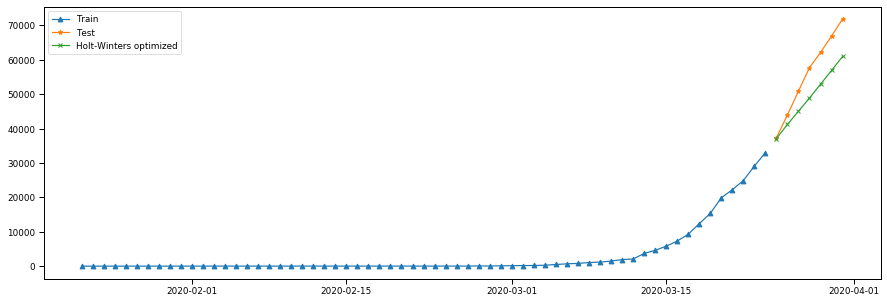

In [977]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=6, damped=False) #Tuned_model

hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

pred = hw_model.predict(start=test.index[0], end=test.index[-1])
pred = pd.DataFrame(pred)
pred.rename(columns={ pred.columns[0]: "Confirmed" }, inplace = True)

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Holt-Winters optimized', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))
print(mean((test.Confirmed - pred.Confirmed) / test.Confirmed))

#['add', False, 'add', 6, False, True]
# t1,d1,s1,p1,b1,r1

9088.117747392029
95.33161987185589
0.7889924891010128
0.14989083767565867


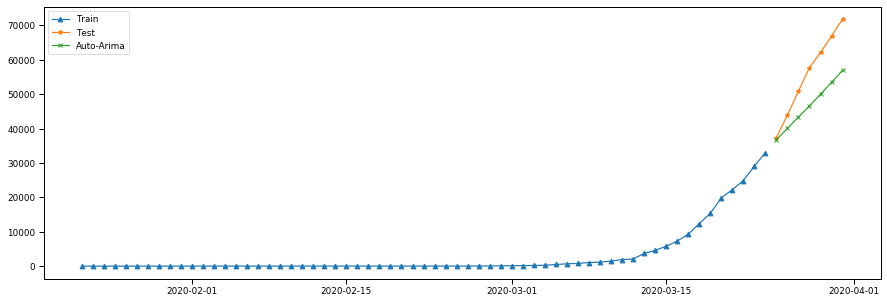

In [978]:
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == "Germany")]

List.index = List['Date']
#List = List.reset_index(drop=True)

train = List.loc[List.Date <= split_date]
test = List.loc[List.Date > split_date]

train = train.fillna(0)
test = test.fillna(0)

train = pd.DataFrame(train['Confirmed'])
test = pd.DataFrame(test['Confirmed'])

stepwise_fit = auto_arima(train, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

stepwise_fit.summary()

pred = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= test.index)

pred.columns = ['Confirmed']

plt.plot(train.index, train, label='Train',marker ='^')
plt.plot(test.index, test, label='Test', marker = "*")
plt.plot(test.index, pred, label='Auto-Arima', marker = "x")
plt.legend(loc='best')

print(mean_absolute_error(y_pred=pred, y_true=test))
print(np.sqrt(mean_absolute_error(y_pred=pred, y_true=test)))
print(SDMAE(y_pred=pred.Confirmed, y_true=test.Confirmed))
print(mean((test.Confirmed - pred.Confirmed) / test.Confirmed))

### All customers

In [979]:
df_ml_confirmed_var = pd.DataFrame(list(dict.fromkeys(df_ml_confirmed.Province_and_country)))
df_ml_confirmed_var.rename(columns={ df_ml_confirmed_var.columns[0]: "Value" }, inplace = True)
#df_ml_confirmed_var = df_ml_confirmed_var.loc[(df_ml_confirmed_var.Value == "Germany")]
#df_ml_confirmed_var = df_ml_confirmed_var.head(20)

#### Linear Regression

In [994]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    Confirmed_train = List.loc[List.Date <= split_date].copy()
    Confirmed_test = List.loc[List.Date > split_date].copy()
    
    X_train, y_train = create_x_y(Confirmed_train, label='Confirmed')
    X_test, y_test = create_x_y(Confirmed_test, label='Confirmed')

    X_train = X_train.fillna(0)
    X_test = X_test.fillna(0)

    linear_regressor = LinearRegression(fit_intercept=False)  # create object for the class

    linear_regressor.fit(X_train, y_train)

    Confirmed_test['Confirmed_Prediction'] = linear_regressor.predict(X_test)
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Linear Regression"
    
    Train_and_Test_['MPE'] = (Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']

    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Linear = pd.concat(Train_and_Test_temp)
Train_and_Test = pd.concat(Train_and_Test_temp)


Finished!


In [998]:
Train_and_Test_Linear = Train_and_Test_Linear.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.SDMAE.notnull(), 'SDMAE']))
print(mean(Train_and_Test_Linear.loc[Train_and_Test_Linear.MPE.notnull(), 'MPE']))

1298.6947249019597
15.077211629307175
4.193059644869523
-0.25990069292083945


#### Holt-Winters (non-optimized)

In [1000]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    model = ExponentialSmoothing(Confirmed_train_, trend='add', seasonal='add', seasonal_periods=12, damped=False) #base_model
    hw_model = model.fit(optimized=True, use_boxcox=False, remove_bias=True) #base_model

    Confirmed_test['Confirmed_Prediction'] = hw_model.predict(start=test.index[0], end=test.index[-1])
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Holt-Winters Non-optimized"
    
    Train_and_Test_['MPE'] = (Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']

    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_Holt = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_Holt)


Finished!


In [1001]:
Train_and_Test_Holt = Train_and_Test_Holt.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.SDMAE.notnull(), 'SDMAE']))
print(mean(Train_and_Test_Holt.loc[Train_and_Test_Holt.MPE.notnull(), 'MPE']))

332.4168876070544
8.201064953581715
1.9171648711555807
0.11458455495524515


#### Auto-ARIMA

In [1003]:
#Training and Test
def SDMAE(y_true, y_pred): 
    return mean_absolute_error(y_true, y_pred) / np.std(y_true)

Train_and_Test_temp = []

for i in tqdm(df_ml_confirmed_var.Value):
    
    List = df_ml_confirmed.loc[(df_ml_confirmed.Province_and_country == i)]
    
    List.index = List['Date']

    Confirmed_train = List.loc[List.Date <= split_date]
    Confirmed_test = List.loc[List.Date > split_date]

    Confirmed_train = Confirmed_train.fillna(0)
    Confirmed_test = Confirmed_test.fillna(0)

    Confirmed_train_ = pd.DataFrame(Confirmed_train['Confirmed'])
    Confirmed_test_ = pd.DataFrame(Confirmed_test['Confirmed'])

    stepwise_fit = auto_arima(Confirmed_train_, error_action='ignore', trace=False,
                      suppress_warnings=True, maxiter=100,
                      seasonal=True, stepwise=True)  # set to stepwise

    stepwise_fit.summary()

    Confirmed_test['Confirmed_Prediction'] = pd.DataFrame(stepwise_fit.predict(n_periods=7), index= Confirmed_test_.index)
    
    Train_and_Test_ = pd.concat([Confirmed_test, Confirmed_train], axis=0, sort=False)
    
    Train_and_Test_['Model'] = "Auto-ARIMA"
    
    Train_and_Test_['MPE'] = (Confirmed_test['Confirmed'] - Confirmed_test['Confirmed_Prediction']) / Confirmed_test['Confirmed']

    Train_and_Test_['MAE'] = mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])

    Train_and_Test_['RMSE'] = np.sqrt(mean_absolute_error(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed']))
    
    Train_and_Test_['SDMAE'] = SDMAE(y_pred=Confirmed_test['Confirmed_Prediction'], y_true=Confirmed_test['Confirmed'])
    
    Train_and_Test_temp.append(Train_and_Test_)
    
print("Finished!")

Train_and_Test_ARIMA = pd.concat(Train_and_Test_temp)
Train_and_Test = Train_and_Test.append(Train_and_Test_ARIMA)


Finished!


In [1005]:
Train_and_Test_ARIMA = Train_and_Test_ARIMA.replace([np.inf, -np.inf], np.nan)
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MAE.notnull(), 'MAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.RMSE.notnull(), 'RMSE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.SDMAE.notnull(), 'SDMAE']))
print(mean(Train_and_Test_ARIMA.loc[Train_and_Test_ARIMA.MPE.notnull(), 'MPE']))

298.63087107547284
8.09182028114139
1.5085462824669966
0.09393607341936575


In [1006]:
Train_and_Test.to_csv('Train_and_Test.CSV',sep=',')